# Profiling for extract_dHdl() In Detail

## Overview

Based on the last discussion and the previous profiling results, we identified that reading a large number of small files is a bottleneck and there is more to investigate for the long processing time. This ipython notebook discusses the further investigation with the two experiments, 
- profiling results for the alchemlyb GROMACS parsing function, ``extract_dHdl()`` 
   - pd.DataFrame conversion is expensive
- cost of writing/reading hdf5 structured binary format

### Profiling pd.DataFrame inside of ``extract_dHdl()``

Processing time is not entirely dependent on a large number of small files to read, conversion to Pandas DataFrame is another big portion of the bottleneck. Profiling result indicates that ``_extract_dataframe()`` function below consumes 88.3% time of ``extract_dHdl()`` function call, and what it does is that parses headers and builds pd.DataFrame from a GROMACS xvg file.

The simple conversion to pd.DataFrame consumes 47.1% of time (See Line 188) and this is where concurrent execution can reduce the processing time. The practical issue is a Lustre filesystem locking for accessing files in a same directory. Opening many files in the same directory creates contention according to the documentation†, and this experiment shows that there are 25,000 files dividied by 106 sims parent directories resulting in average 236 files in the same directory to read. We need a test run to verify if this is true for file reading, not writing.

†Lustre Best Practices: https://www.nas.nasa.gov/hecc/support/kb/lustre-best-practices_226.html

```
(alchemlyb) [hrlee@login018 ~]$ python -m line_profiler analysis.nodask.py.lprof
Timer unit: 1e-06 s

Total time: 14278.7 s
File: /home/hrlee/.conda/envs/alchemlyb/lib/python3.7/site-packages/alchemlyb/parsing/gmx.py
Function: extract_dHdl at line 82

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    82
    83                                           def extract_dHdl(xvg, T):
...(omitted)...
    97     25089      54164.0      2.2      0.0      beta = 1/(k_b * T)
    98
    99     25089 1262148551.0  50306.8      8.8      state, lambdas, statevec = _extract_state(xvg)
   100
   101                                               # extract a DataFrame from XVG data
   102     25089 12611389601.0 502666.1     88.3      df = _extract_dataframe(xvg)

...(omitted)...

```

```
Total time: 11287.7 s
File: /home/hrlee/.conda/envs/alchemlyb/lib/python3.7/site-packages/alchemlyb/parsing/gmx.py
Function: _extract_dataframe at line 153

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   153
   154                                           def _extract_dataframe(xvg):
   155                                               """Extract a DataFrame from XVG data.
   156
   157                                               """
   158     25089    7650896.0    305.0      0.1      with anyopen(xvg, 'r') as f:
   159     25089      44973.0      1.8      0.0          names = []
   160     25089      23741.0      0.9      0.0          rows = []
   161 206530593 1768891547.0      8.6     15.7          for line in f:
   162 206505504  176606311.0      0.9      1.6              line = line.strip()
   163 206505504  151686186.0      0.7      1.3              if len(line) == 0:
   164                                                           continue
   165
   166 206505504  164058596.0      0.8      1.5              if "label" in line and "xaxis" in line:
   167     25089      57774.0      2.3      0.0                  xaxis = line.split('"')[-2]
   168
   169 206505504  564111193.0      2.7      5.0              if line.startswith("@ s") and "subtitle" not in line:
   170   2116821    2960341.0      1.4      0.0                  name = line.split("legend ")[-1].replace('"','').strip()
   171   2116821    1563486.0      0.7      0.0                  names.append(name)
   172
   173                                                       # should catch non-numeric lines so we don't proceed in parsing
   174                                                       # here
   175 206505504  150227213.0      0.7      1.3              if line.startswith(('#', '@')) :
   176   2693868    1679231.0      0.6      0.0                  continue
   177
   178 203811636  144638777.0      0.7      1.3              if line.startswith('&'):
   179                                                           raise NotImplementedError('{}: Multi-data not supported,'
   180                                                                                     'only simple NXY format.'.format(xvg))
   181                                                       # parse line as floats
   182 203811636 2696231020.0     13.2     23.9              row = map(float, line.split())
   183 203811636  143656049.0      0.7      1.3              rows.append(row)
   184
   185     25089      58698.0      2.3      0.0      cols = [xaxis]
   186     25089     189198.0      7.5      0.0      cols.extend(names)
   187
   188     25089 5313358786.0 211780.4     47.1      return pd.DataFrame(rows, columns=cols)
```

### HDF5 Write/Read (In Progress)

Alchemlyb provides convenient data storage and retrieval in HDF5 hierarchical data format (see the details: [datreant](https://github.com/datreant/datreant)), this experiment is to measure an elapsed time for writing and reading hdf5 in the ``get_dHdl()`` function of [the original process](https://github.com/hpcanalytics/midas-alchemlyb/blob/master/analysis.ipynb). The following results indicate that some extra time is required to write hdf5 files but reading hdf5 instead of parsing xvg files again is a huge improvement for reducing the processing time. In detail, the implementation is:

```python
def get_dHdl(sim, lower=None, upper=None, step=None):
    try:
        # Reading hdf5, if exists
        dHdl = sim.data.retrieve('dHdl') 
        ...(omitted)...
    except:
        dHdl = get_dHdl_XVG(sim, lower=lower, upper=upper, step=step)
        # NEW: Writing hdf5 of the pandas DataFrame, dHdl, concatenated.
        sim.data['dHdl'] = dHdl
    
    return dHdl
```


In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df_h5_write = pd.read_csv(open("logs/get_dHdl.nodask.hdf5_write.log"), sep=",",quotechar = '\'')
df_h5_read = pd.read_csv(open("logs/get_dHdl.nodask.hdf5_read.log"), sep=",",quotechar = '\'')

Log files are available at [hdf5_read.log](https://github.com/hpcanalytics/midas-alchemlyb/blob/master/logs/get_dHdl.nodask.hdf5_read.log), [hdf5_write.log](https://github.com/hpcanalytics/midas-alchemlyb/blob/master/logs/get_dHdl.nodask.hdf5_write.log)

### HDF5 Write

Storing h5 file is useful for later use, and the following bar chart tells us how much time it needs to store additionally.

Text(0,0.5,u'Elapsed Time (Second)')

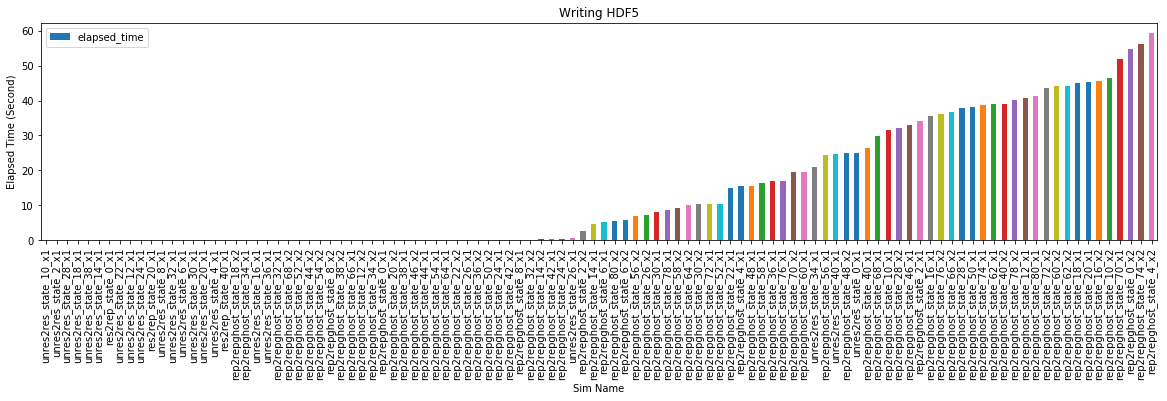

In [3]:
df_h5_write = df_h5_write.sort_values(by=['elapsed_time']).reset_index(drop=True)
df_h5_write = df_h5_write[df_h5_write.type == "hdf5_write"]
ax = df_h5_write.plot.bar(x='sim',y='elapsed_time', figsize=(20,4))
ax.set_title("Writing HDF5")
ax.set_xlabel("Sim Name")
ax.set_ylabel("Elapsed Time (Second)")

Note that each sim concatenates pd.DataFrame extracted from about 10 to 280 xvg files and store a single h5 file. The distance of elapsed time among them is too large, it can be due to Lustre contention or other unknown issues.

### HDF5 Read

Our first run (without Dask) completed in 3 hours and 30 minutes for processing 25k files, and it can be reduced in 2 minutes, just reading 106 (sim size) h5 files.

```
5105885.ext+ extern COMPLETED 2019-03-21T00:36:49 2019-03-21T00:38:52   00:02:03 808K 140656K 1 28 r079 
```

Text(0,0.5,u'Elapsed Time (Second)')

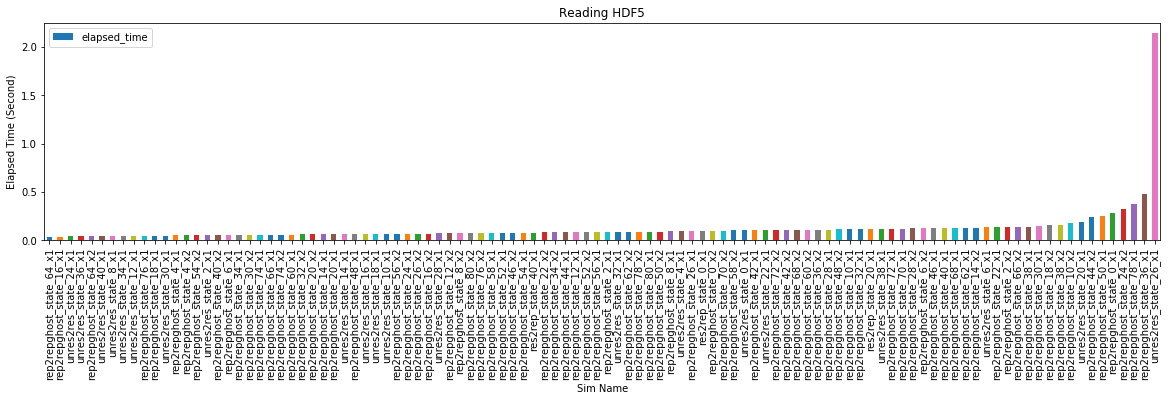

In [4]:
df_h5_read = df_h5_read.sort_values(by=['elapsed_time']).reset_index(drop=True)

ax = df_h5_read.plot.bar(x='sim',y='elapsed_time', figsize=(20,4))
ax.set_title("Reading HDF5")
ax.set_xlabel("Sim Name")
ax.set_ylabel("Elapsed Time (Second)")

# Conclusion

We are still in a exploring mode to find an optimal solution in dealing with a large number of intermediate files (typically small sizes). Code refactoring can be an easy answer to improve (if code is available to fix and implemented without performance consideration) but our approach needs to be a higher level to suggest a general resolution.

Distributed file access performance is dependent on a hardware specification (e.g. SSD, NVMe) and a file system (e.g. Lustre) along with operating system configuration. Best practice to achieve optimal performance starts from understanding existing system and configuration, otherwise a simple mistake can create a huge bottleneck easily.

The couple of experiments indicate that 1) concurrent data file processing divided by multiple directories will reduce the enrie processing time, and 2) conversion to hdf5 format will provide better performance for later use over the ascii plain text file.

Future work includes the following experiments: 1) file re-distribution on Lustre, 2) conversion cost to hdf5, 3) data moving cost for reading in memdisk or SSD, 4) replacing file output by memory using a Python API, e.g. [gmxapi](https://github.com/kassonlab/gmxapi) or using a queueing system e.g. ZMQ.